# MaterialPointSolver.jl Showcase 02

Author: Zenan Huo <br>
Date: 25-Aug-2024 <br>

---

This case is the 3D soil collapse test in MPM. You can compare to showcase 01 to see the differences.

In [1]:
using MaterialPointGenerator
using MaterialPointSolver
using MaterialPointVisualizer
using CairoMakie
using CUDA

┌ Info: checking environment...
└ @ MaterialPointGenerator /home/zhuo/Workbench/MaterialPointGenerator.jl/src/MaterialPointGenerator.jl:33
┌ Info: embreex loaded
└ @ MaterialPointGenerator /home/zhuo/Workbench/MaterialPointGenerator.jl/src/MaterialPointGenerator.jl:57
┌ Info: checking environment...
└ @ MaterialPointVisualizer /home/zhuo/Workbench/MaterialPointVisualizer.jl/src/MaterialPointVisualizer.jl:29


In [2]:
MaterialPointSolver.warmup(Val(:CUDA)) # optional

┌ Info: warming up on :CUDA [0] 🔥
└ @ MaterialPointSolverCUDAExt /home/zhuo/Workbench/MaterialPointSolver.jl/ext/CUDAExt/warmup_cuda.jl:23


In [3]:
init_grid_space_x = 0.0025
init_grid_space_y = 0.0025
init_grid_space_z = 0.0025
init_grid_range_x = [-0.02, 0.07]
init_grid_range_y = [-0.02, 0.75]
init_grid_range_z = [-0.02, 0.12]
init_mp_in_space  = 2
init_T            = 1
init_ρs           = 2650
init_ν            = 0.3
init_Ks           = 7e5
init_Es           = init_Ks * (3 * (1 - 2 * init_ν))
init_Gs           = init_Es / (2 * (1 +     init_ν))
init_ΔT           = 0.5 * init_grid_space_x / sqrt(init_Es / init_ρs)
init_step         = floor(init_T / init_ΔT / 50)
init_ϕ            = deg2rad(19.8)
init_FP           = "FP64"
init_basis        = :bspline2
init_NIC          = 9;

### Parameters Setup

In [4]:
args = UserArgs3D(
    Ttol         = init_T,
    Te           = 0,
    ΔT           = init_ΔT,
    time_step    = :fixed,
    FLIP         = 1,
    PIC          = 0,
    constitutive = :druckerprager,
    basis        = init_basis,
    hdf5         = false,
    hdf5_step    = init_step,
    MVL          = false,
    device       = :CUDA,
    coupling     = :OS,
    scheme       = :USF,
    gravity      = -9.8,
    ζs           = 0,
    project_name = "3d_druckerprager",
    project_path = @__DIR__,
    ϵ            = init_FP
)

DeviceArgs3D:
┬────────────
├─ project name    : 3d_druckerprager
├─ project path    : /home/zhuo/Workbench/MaterialPointSolver.jl/examples/1phase1point
├─ precision       : FP64
├─ constitutive    : druckerprager
├─ basis method    : bspline2
├─ mitigate vollock: false
└─ coupling scheme : OS


### Background Grid Setup

In [5]:
grid = UserGrid3D(
    ϵ     = init_FP,
    phase = 1,
    x1    = init_grid_range_x[1],
    x2    = init_grid_range_x[2],
    y1    = init_grid_range_y[1],
    y2    = init_grid_range_y[2],
    z1    = init_grid_range_z[1],
    z2    = init_grid_range_z[2],
    dx    = init_grid_space_x,
    dy    = init_grid_space_y,
    dz    = init_grid_space_z,
    NIC   = init_NIC
)

DeviceGrid3D:
┬────────────
├─ phase  : 1
├─ NIC    : 27
├─ ϵ      : FP64
├─ x1 - x2: -0.02 - 0.07
├─ y1 - y2: -0.02 - 0.75
├─ z1 - z2: -0.02 - 0.12
├─ d x-y-z: 0.0025 - 0.0025 - 0.0025
├─ nc     : 6.21e+05
└─ ni     : 6.52e+05


### Material Points Setup

In [6]:
dx = grid.dx / init_mp_in_space
dy = grid.dy / init_mp_in_space
dz = grid.dz / init_mp_in_space
pts = meshbuilder(0 + dx / 2 : dx : 0.05 - dx / 2,
                  0 + dy / 2 : dy : 0.20 - dy / 2,
                  0 + dz / 2 : dz : 0.10 - dz / 2)
mpρs = ones(size(pts, 1)) * init_ρs
mp = UserParticle3D(
    ϵ     = init_FP,
    phase = 1,
    NIC   = init_NIC,
    dx    = dx,
    dy    = dy,
    dz    = dz,
    ξ     = pts,
    ρs    = mpρs
)

DeviceParticle3D:
┬────────────────
├─ phase  : 1
├─ NIC    : 27
├─ ϵ      : FP64
├─ d x-y-z: 0.00125 - 0.00125 - 0.00125
└─ np     : 5.12e+05


### Particle Property Setup

In [7]:
nid = ones(mp.np)
attr = UserProperty(
    ϵ   = init_FP,
    nid = nid,
    ν   = [init_ν],
    Es  = [init_Es],
    Gs  = [init_Gs],
    Ks  = [init_Ks],
    σt  = [0],
    ϕ   = [init_ϕ],
    ϕr  = [0],
    ψ   = [0],
    c   = [0],
    cr  = [0],
    Hp  = [0]
)

DeviceProperty:
┬──────────────
└─ ϵ: FP64


### Boundary Condition Nodes Index

In [8]:
vx_idx  = zeros(grid.ni)
vy_idx  = zeros(grid.ni)
vz_idx  = zeros(grid.ni)
tmp_idx = findall(i -> grid.ξ[i, 1] ≤ 0 || grid.ξ[i, 1] ≥ 0.05 ||
                       grid.ξ[i, 3] ≤ 0 || grid.ξ[i, 2] ≤ 0, 1:grid.ni)
tmp_idy = findall(i -> grid.ξ[i, 2] ≤ 0 || grid.ξ[i, 3] ≤ 0, 1:grid.ni)
tmp_idz = findall(i -> grid.ξ[i, 3] ≤ 0, 1:grid.ni)
vx_idx[tmp_idx] .= 1
vy_idx[tmp_idy] .= 1
vz_idx[tmp_idz] .= 1
bc = UserVBoundary3D(
    ϵ        = init_FP,
    vx_s_idx = vx_idx,
    vx_s_val = zeros(grid.ni),
    vy_s_idx = vy_idx,
    vy_s_val = zeros(grid.ni),
    vz_s_idx = vz_idx,
    vz_s_val = zeros(grid.ni)
)

DeviceVBoundary3D:
┬─────────────────
└─ ϵ: FP64


### MPM Solver

In [9]:
materialpointsolver!(args, grid, mp, attr, bc)

┌ Info: 3d_druckerprager [3D/CUDA]
│ ────────────────┬─────────────┬────────────────────
│ ΔT  : 7.02e-05s │ PIC :  0.00 │ scheme   : USF
│ Ttol: 1.00e+00s │ FLIP:  1.00 │ coupling : OS
│ pts : 5.12e+05  │ ζs  :  0.00 │ basis    : bspline2
│ nds : 6.52e+05  │ ζw  :  0.00 │ precision: FP64
│ MVL :    false  │ HDF5: false │ material : D-P
│ ────────────────┴─────────────┴────────────────────
└ @ MaterialPointSolver /home/zhuo/Workbench/MaterialPointSolver.jl/src/toolkits/terminaltxt.jl:49


[▲ I/O: uploading [≈ 0.9 GiB] → :CUDA [0]


[ Info: solving 100% ■■■■■■■■■■■■  Time: 0:01:13


[▼ I/O: downloading from :CUDA [0] → host
[• I/O: free device [0] memory


┌ Info: performance
│ ────────────────────
│ wtime: 00:01:13
│ iters: 1.42e+04
│ speed: 1.95e+02 it/s
│ ────────────────────
└ @ MaterialPointSolver /home/zhuo/Workbench/MaterialPointSolver.jl/src/toolkits/terminaltxt.jl:78


### Post processing

* save to `.vtp` for ParaView:

In [10]:
savevtp(args, grid, mp, attr)

┌ Info: final vtp file is saved in project path
└ @ MaterialPointVisualizer /home/zhuo/Workbench/MaterialPointVisualizer.jl/src/mpm2vtp.jl:100


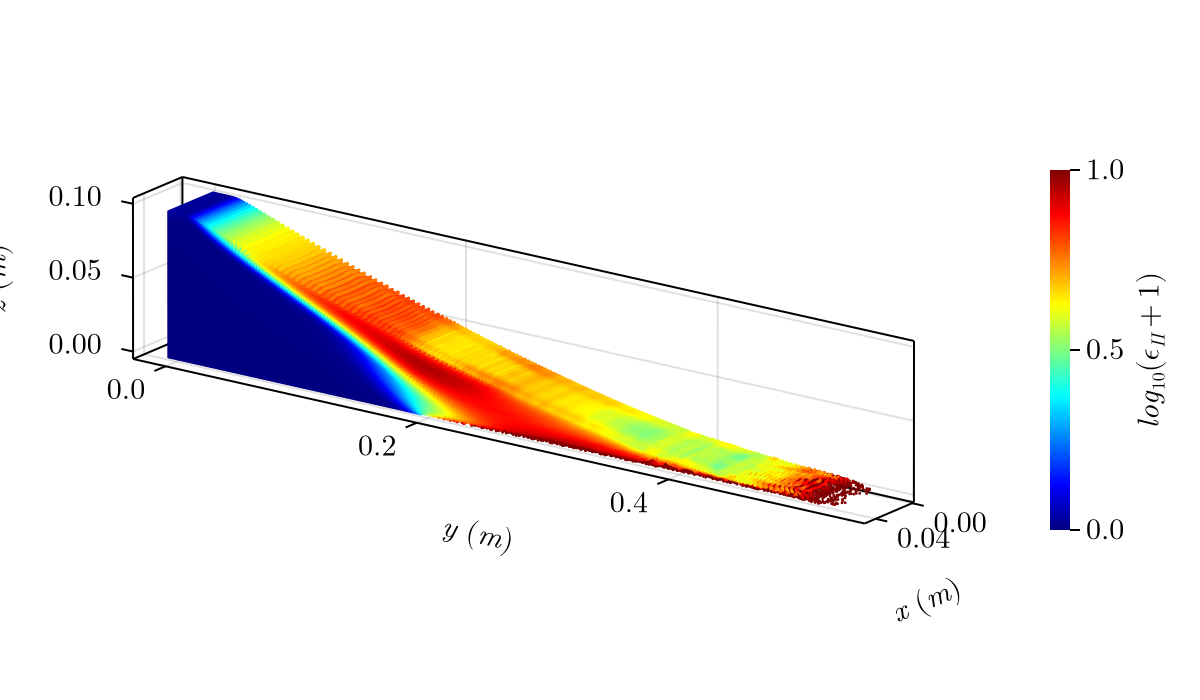

In [11]:
let
    set_theme!(theme_latexfonts())
    fig = Figure(size=(600, 350), fontsize=15)
    ax = Axis3(fig[1, 1], xlabel=L"x\ (m)", ylabel=L"y\ (m)", zlabel=L"z\ (m)", 
        aspect=:data, azimuth=0.2*π, elevation=0.1*π, zlabeloffset=60, xlabeloffset=40, 
        protrusions=50, xticks=(0:0.04:0.04))
    pl1 = scatter!(ax, mp.ξ, color=log10.(mp.ϵq.+1), colormap=:jet, markersize=2,
        colorrange=(0, 1))
    Colorbar(fig[1, 2], limits=(0, 1), colormap=:jet, ticks=0:0.5:1, spinewidth=0,
        label=L"log_{10}(\epsilon_{II}+1)", tellwidth=true, width=10)
    rowsize!(fig.layout, 1, 180)
    display(fig)
end;

In [12]:
# run this if you want to clean all the generated files from this simulation:
# rm(joinpath(args.project_path, args.project_name), recursive=true, force=true)